## Extract model laminar signals

Record and plot LFPs and CSDs from HNN model extracellular HNN potentials. 
The position of the shank recordings is specified in *model_merf.py*:
- In this study we used 11 shanks, corresponding to the 11 surfaces of the Lameg source reconstruction
- The L2/3 and L5 position
- Shank positions as well as the overall cortical thickness was adapted to the primary motor cortex layer boundaries (from vertex where the activity is modeled)

From "Record extracellular potentials" HNN tutorial https://jonescompneurolab.github.io/hnn-core/stable/auto_examples/howto/plot_record_extracellular_potentials.html#sphx-glr-auto-examples-howto-plot-record-extracellular-potentials-py

In [1]:
import os
import json
import numpy as np
from matplotlib import pyplot as plt
from model_merf import set_params
from hnn_core import read_dipole, simulate_dipole, MPIBackend, JoblibBackend, law_2021_model, jones_2009_model
from hnn_core.dipole import average_dipoles, plot_dipole
from hnn_utils import plot_mean_lfp, plot_mean_csd

In [2]:
%env OMPI_TMPDIR=/scratch
%env TMPDIR=/scratch

env: OMPI_TMPDIR=/scratch
env: TMPDIR=/scratch


In [3]:
%env TMPDIR

'/scratch'

In [4]:
#base_data_dir='/home/bonaiuto/laminar_csd/data'
base_data_dir='data'
subject='sub-001'
session='ses-01'
c_idx=3
epoch='motor'
data_dir=os.path.join(base_data_dir, subject, session)
hnn_dir=os.path.join(data_dir, f'{subject}_{session}_c{c_idx}_{epoch}_hnn')

In [5]:
with open(os.path.join(hnn_dir, f'{subject}_{session}_c{c_idx}_{epoch}_erf_opt_params.json'), 'r') as f:
    optim_params = json.load(f)

In [6]:
with open('initial_params_v2.json', 'r') as f:
    optim_params = json.load(f)

In [7]:
#net = law_2021_model()
net = jones_2009_model()
net = set_params(net, optim_params, sim_shank=True)

Setting parameters: {'rydist1_ampa_L2_basket': 0.0011, 'rydist1_ampa_L2_pyramidal': 0.0027, 'rydist1_ampa_L5_pyramidal': 0.0028, 'rydist1_mu': 734.0, 'rydist1_sigma': 57.6, 'evdist2_ampa_L2_basket': 0.6121579707704913, 'evdist2_ampa_L2_pyramidal': 0.6245584647492026, 'evdist2_ampa_L5_pyramidal': 0.973528322653582, 'evdist2_nmda_L2_basket': 0.57986418705435, 'evdist2_nmda_L2_pyramidal': 0.5721657338349071, 'evdist2_nmda_L5_pyramidal': 0.17769272341378614, 'evdist2_mu': 905.7168241599677, 'evdist2_sigma': 31.742683478914483, 'evprox1_ampa_L2_basket': 0.33628891212190765, 'evprox1_ampa_L2_pyramidal': 0.1966689920786076, 'evprox1_ampa_L5_basket': 0.24782769133545213, 'evprox1_ampa_L5_pyramidal': 0.6316976139923263, 'evprox1_nmda_L2_basket': 0.12023257681765015, 'evprox1_nmda_L2_pyramidal': 0.5582628412600553, 'evprox1_nmda_L5_basket': 0.9959616253769533, 'evprox1_nmda_L5_pyramidal': 0.05209955437498684, 'evprox1_mu': 1012.7509215159755, 'evprox1_sigma': 10.739724779230636, 'evprox2_ampa_L2

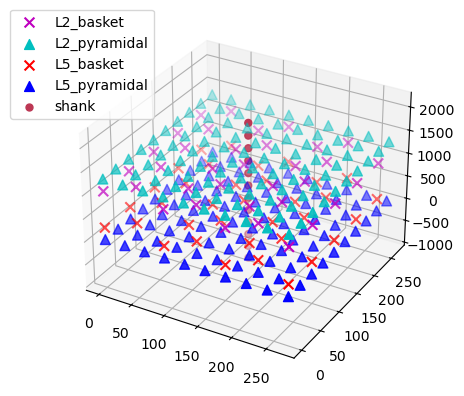

In [8]:
fig = net.plot_cells()
#fig.savefig(f'{hnn_dir}/cell_layout.pdf')

In [9]:
n_trials = 15
tstop = 2000
window_len, scaling_factor = 30, 1250 #estimated 250,000 cells

In [10]:
# Joblib distribute 1 trial per job, whereas MPI distribute 1 trial over the procs
# with JoblibBackend(n_jobs=30):
#     dpls = simulate_dipole(net, tstop=tstop, n_trials=n_trials)

with MPIBackend(n_procs=30, mpi_cmd='mpiexec'):
    dpls = simulate_dipole(net, tstop=tstop, n_trials=n_trials)

/home/sgailhard/miniconda3/envs/hnn/lib/python3.12/site-packages/hnn_core/parallel_backends.py:897: UserWarning: Number of requested MPI processes exceeds available cores. Enabling MPI oversubscription automatically.
  warn(


MPI will run 2 trial(s) sequentially by distributing network neurons over 30 processes.
numprocs=30
/home/sgailhard/miniconda3/envs/hnn/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/sgailhard/miniconda3/envs/hnn/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/sgailhard/miniconda3/envs/hnn/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/sgailhard/miniconda3/envs/hnn/bin/nrniv:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set
/home/sgailhard/miniconda3/envs/hnn/bin/nrniv:10: DeprecationWar

In [11]:
for dpl in dpls:
    dpl.smooth(window_len).scale(scaling_factor)

avg_dpl = average_dipoles(dpls)

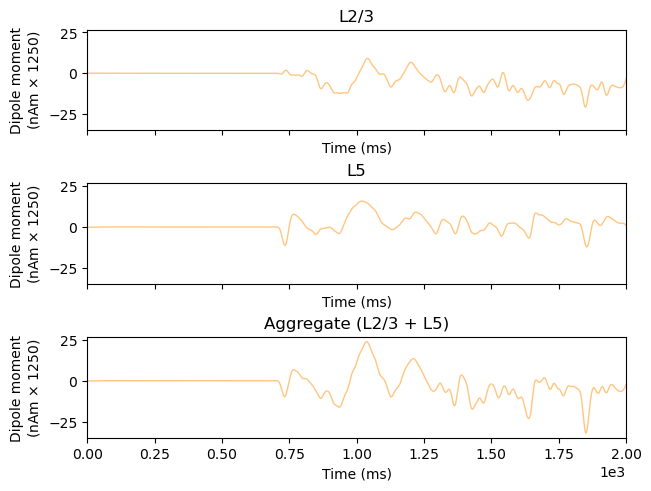

In [12]:
_ = avg_dpl.copy().smooth(
    window_len=window_len).plot(layer=['L2', 'L5', 'agg'],
                                show=False, color='darkorange')

Save the dipoles

In [13]:
avg_dpl.copy().smooth(
    window_len=window_len).write(os.path.join(hnn_dir, f"dipole_merf_{n_trials}t.txt"))

/home/sgailhard/miniconda3/envs/hnn/lib/python3.12/site-packages/hnn_core/dipole.py:752: UserWarning: Saving Dipole to file that is an average of 2 trials
  warnings.warn(


Plot the LFP traces and the CSD

In [15]:
lfps = net.rec_arrays['shank'].smooth(window_len=window_len)

In [16]:
mean_lfps_traces = lfps.voltages.mean(axis=0)
# Save the lfps traces
np.save(os.path.join(hnn_dir, f'merf_lfps_traces_{n_trials}t.npy'), mean_lfps_traces)

In [17]:
lfps_traces = np.load(os.path.join(hnn_dir, f'merf_lfps_traces_{n_trials}t.npy'), allow_pickle=True)

In [18]:
lfps_traces.shape

(12, 80001)

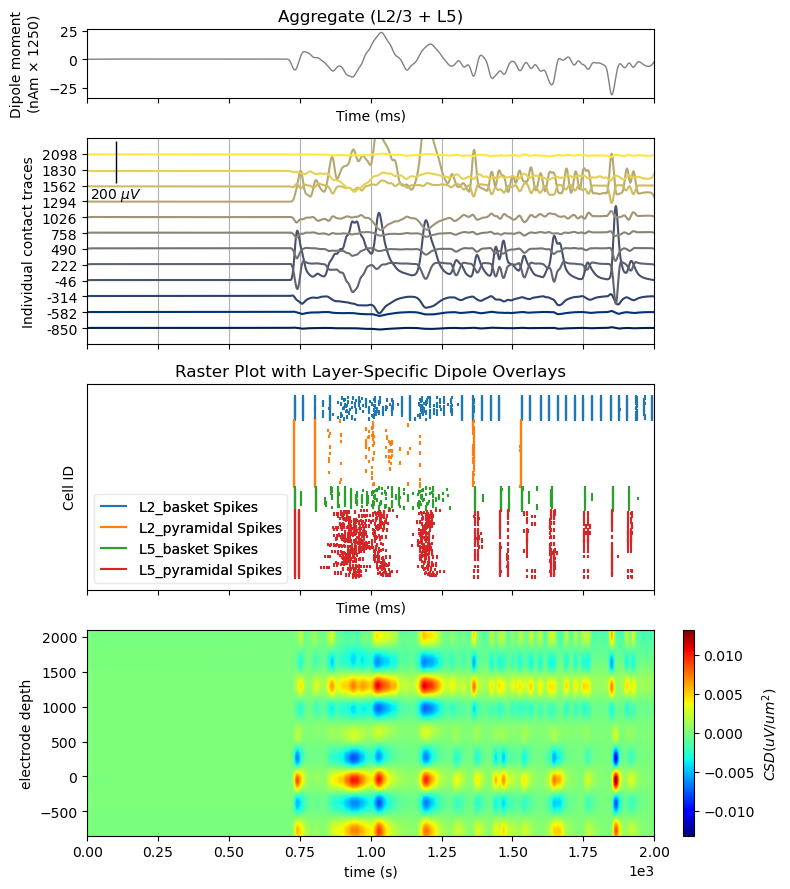

In [19]:
trial_idx = 0
decimate = [5, 4]  # from 40k to 8k to 2k
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(8, 9),
                        gridspec_kw={'height_ratios': [1, 3, 3, 3]})

avg_dpl.smooth(window_len=window_len)
avg_dpl.plot(ax=axs[0], decim=decimate, show=False)

_ = plot_mean_lfp(lfps, trial_no=None, contact_no=None,
             decim=decimate, color='cividis', voltage_offset=75,
             voltage_scalebar=200, show=False, mean=True, ax=axs[1])

axs[1].grid(True, which='major', axis='x')
axs[1].set_xlabel('')

# Add spike raster to subplot
net.cell_response.plot_spikes_raster(trial_idx=trial_idx, ax=axs[2], show=False)

# Finally, add the CSD to the bottom subplot

_ = plot_mean_csd(lfps, ax=axs[3], mean=True, show=False)

plt.tight_layout()
#fig.savefig(f'{hnn_dir}/trials.pdf')